In [21]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
from sklearn.metrics import confusion_matrix
import time
import os
import sys
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

plt.style.use('_mpl-gallery')


tf.enable_v2_behavior()


BATCH_SIZE = 256
NUM_EPOCHS = 12
IMAGE_SHAPE = (224,224,3)
ALPHA = 0.5
DISTILLATION_TEMPERATURE = 4


# Model creation

In [3]:
teacher_model = tf.keras.applications.ResNet50V2(
  include_top=False,
  weights='imagenet',
  classes=2,
  input_shape=IMAGE_SHAPE
  )
teacher_model.trainable=False

###################
#Joyce-ZhouY
#https://github.com/Joyce-ZhouY/ECE1512-ProjectA/blob/main/Task2.ipynb
###################
inputs = tf.keras.Input(shape=(224, 224, 3))
x = teacher_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(dtype='float32')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)
teacher_model = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
initial_epoch = 10
teacher_model.compile(optimizer=optimizer)


94668760/94668760 [==============================] - 0s 0us/step


In [5]:
student_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights="imagenet",
    classes=2,
)
student_model.trainable=False

###################
#Joyce-ZhouY
#https://github.com/Joyce-ZhouY/ECE1512-ProjectA/blob/main/Task2.ipynb
###################
inputs = tf.keras.Input(shape=(224, 224, 3))
x = student_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(dtype='float32')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)
student_model = tf.keras.Model(inputs, outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
initial_epoch = 10
student_model.compile(optimizer=optimizer
)

9406464/9406464 [==============================] - 0s 0us/step


In [6]:
###################
#Joyce-ZhouY
#https://github.com/Joyce-ZhouY/ECE1512-ProjectA/blob/main/Task2.ipynb
###################
path_train = '/content/train'
tf.io.gfile.mkdir(
    path_train
)

path_test = '/content/test'
tf.io.gfile.mkdir(
    path_test
)

path_train_HP = '/content/train/HP'
tf.io.gfile.mkdir(
    path_train_HP
)

path_train_SSA = '/content/train/SSA'
tf.io.gfile.mkdir(
    path_train_SSA
)

path_test_HP = '/content/test/HP'
tf.io.gfile.mkdir(
    path_test_HP
)

path_test_SSA = '/content/test/SSA'
tf.io.gfile.mkdir(
    path_test_SSA
)

path_train_aug = '/content/train_aug'
tf.io.gfile.mkdir(
    path_train_aug
)

path_train_HP_aug = '/content/train_aug/HP'
tf.io.gfile.mkdir(
    path_train_HP_aug
)

path_train_SSA_aug = '/content/train_aug/SSA'
tf.io.gfile.mkdir(
    path_train_SSA_aug
)

path = '/content/annotations.csv'
df = pd.read_csv(path)
csv = dict(df)
image_num = len(csv.get('Image Name'))


for i in range(image_num):
  if csv.get('Partition')[i] == "train":
    if csv.get('Majority Vote Label')[i] == "HP":
      src = '/content/drive/MyDrive/images/' + csv.get('Image Name')[i]
      #/content/drive/MyDrive/images
      dst = '/content/train/HP/' + csv.get('Image Name')[i]
      tf.io.gfile.copy(src, dst, overwrite=True)
    else:
      src = '/content/drive/MyDrive/images/' + csv.get('Image Name')[i]
      dst = '/content/train/SSA/' + csv.get('Image Name')[i]
      tf.io.gfile.copy(src, dst, overwrite=True)
  else:
    if csv.get('Majority Vote Label')[i] == "HP":
      src = '/content/drive/MyDrive/images/' + csv.get('Image Name')[i]
      dst = '/content/test/HP/' + csv.get('Image Name')[i]
      tf.io.gfile.copy(src, dst, overwrite=True)
    else:
      src = '/content/drive/MyDrive/images/' + csv.get('Image Name')[i]
      dst = '/content/test/SSA/' + csv.get('Image Name')[i]
      tf.io.gfile.copy(src, dst, overwrite=True)

In [7]:
import matplotlib. image as image
from matplotlib import pyplot as plt
from random import random

path = '/content/annotations.csv'
df = pd.read_csv(path)
csv = dict(df)
image_num = len(csv.get('Image Name'))

###################
#Joyce-ZhouY
#https://github.com/Joyce-ZhouY/ECE1512-ProjectA/blob/main/Task2.ipynb
###################
for i in range(image_num):
    if csv.get('Majority Vote Label')[i] == "HP":
      src = '/content/drive/MyDrive/images/' + csv.get('Image Name')[i]
      img=image.imread(src)
      img_aug = tf.image.rot90(tf.image.random_flip_up_down(img),k=round(random()*3))+tf.random.normal(shape=[224,224,3], mean=0.0, stddev=0.1,dtype=tf.float32)
      tf.keras.utils.save_img('/content/train_aug/HP/'+ csv.get('Image Name')[i], img_aug, data_format=None, file_format=None, scale=True)
    else:
      src = '/content/drive/MyDrive/images/' + csv.get('Image Name')[i]
      img=image.imread(src)
      img_aug = tf.image.rot90(tf.image.random_flip_up_down(img),k=round(random()*3))+tf.random.normal(shape=[224,224,3], mean=0.0, stddev=0.1,dtype=tf.float32)
      tf.keras.utils.save_img('/content/train_aug/SSA/'+ csv.get('Image Name')[i], img_aug, data_format=None, file_format=None, scale=True)
      #break

In [8]:
###################
#Joyce-ZhouY
#https://github.com/Joyce-ZhouY/ECE1512-ProjectA/blob/main/Task2.ipynb
###################
IMG_SIZE = (224,224)
train_dir = '/content/train_aug'
BATCH_SIZE=32
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                              shuffle=True,
                              batch_size=BATCH_SIZE,
                              image_size=IMG_SIZE)

test_dir = '/content/test'
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                              shuffle=True,
                              batch_size=BATCH_SIZE,
                              image_size=IMG_SIZE)

Found 3152 files belonging to 2 classes.
Found 977 files belonging to 2 classes.


In [9]:

train_dataset = train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.one_hot(y, 2)))
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32), tf.one_hot(y, 2)))

In [29]:
def f1(tp,tn,fp):
    precision=tp/(tp+tn)
    recall=tp/(tp+fp)
    return 2*((precision*recall)/(precision+recall))

def compute_teacher_loss(images, labels):
  subclass_logits = teacher_model(images, training=True)
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits)
  return cross_entropy_loss_value

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2


def compute_student_loss(images, labels):
  student_subclass_logits = student_model(images, training=True)
  teacher_subclass_logits = teacher_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits)
  loss= ALPHA*distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value
  return loss

def compute_plain_cross_entropy_loss(images, labels):
  student_subclass_logits = student_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  return cross_entropy_loss

def compute_confusion_matrix(model, images, labels):
  y_prediction = model(images, training=False)
  y_prediction = np.argmax (y_prediction, axis = 1)
  y_true=np.argmax(labels, axis=1)

  result = confusion_matrix(y_true, y_prediction)
  return result


def compute_num_correct(model, images, labels):
  class_logits = model(images, training=False)
  value= tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)
  return value

###################
#Joyce-ZhouY
#https://github.com/Joyce-ZhouY/ECE1512-ProjectA/blob/main/Task2.ipynb
###################
def train_and_evaluate(model, compute_loss_fn):
  time_matrix=[]
  matrix_1 = []
  for epoch in range(1, NUM_EPOCHS + 1):
    start_time = time.time()
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in train_dataset:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images,labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    con_matrix=[[0,0],[0,0]]
    for images, labels in test_dataset:
      acc = compute_confusion_matrix(model, images, labels)
      con_matrix[0][0] += acc[0][0]
      con_matrix[0][1] += acc[0][1]
      con_matrix[1][0] += acc[1][0]
      con_matrix[1][1] += acc[1][1]
      #print(con_matrix)

    epoch_time = time.time() - start_time
    time_matrix.append(epoch_time)
    #print("Total time per epoch: {0:.2f} seconds".format(epoch_time))

    con_matrix = np.asarray(con_matrix)
    f1_score = f1(con_matrix[0][0], con_matrix[0][1], con_matrix[1,0])
    matrix_1.append(f1_score)

  total_time = np.sum(time_matrix)

  return f1_score

# Training models

In [22]:
f1_score = train_and_evaluate(teacher_model, compute_teacher_loss)

Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: 

In [23]:
f1_score

0.768642447418738

In [25]:
f1_score = train_and_evaluate(student_model, compute_student_loss)

Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: 

In [26]:
f1_score

0.7741530740276036

# Train student from scratch

In [27]:
student_model_no_distillation = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights="imagenet",
    classes=2,
)
student_model_no_distillation.trainable=False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = student_model_no_distillation(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(dtype='float32')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)
student_model_no_distillation = tf.keras.Model(inputs, outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
initial_epoch = 10
student_model_no_distillation.compile(optimizer=optimizer
)

In [30]:
f1_before_kd = train_and_evaluate(student_model_no_distillation, compute_plain_cross_entropy_loss)
f1_before_kd

Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: 

0.7726130653266331

In [ ]:
pip install py-markdown-table

In [34]:
from py_markdown_table.markdown_table import markdown_table
data = [
    {
        "Temperature = 4, Alpha = 0.5 ": "F1 Score",
        "Student Model before KD": '{:.4f}'.format(f1_before_kd),
        "Student Model after KD": '{:.4f}'.format(f1_score),
    },
]
table = markdown_table(data).get_markdown()
print(table)

```
+----------------------------------------------------------------------------+
|Temperature = 4, Alpha = 0.5 |Student Model before KD|Student Model after KD|
+-----------------------------+-----------------------+----------------------+
|           F1 Score          |         0.7726        |        0.7742        |
+----------------------------------------------------------------------------+```


# Test accuracy vs. tempreture curve

In [41]:
student_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights="imagenet",
    classes=2,
)
student_model.trainable=False

# Create new model on top.
inputs = tf.keras.Input(shape=(224, 224, 3))
x = student_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(dtype='float32')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)
student_model = tf.keras.Model(inputs, outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
initial_epoch = 10
student_model.compile(optimizer=optimizer
)

In [44]:
ALPHA = 0.5
f1_list = []
for t in [ 2, 4, 16, 32, 64]:
  DISTILLATION_TEMPERATURE = t
  f1_list.append(train_and_evaluate(student_model, compute_student_loss))


Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: 

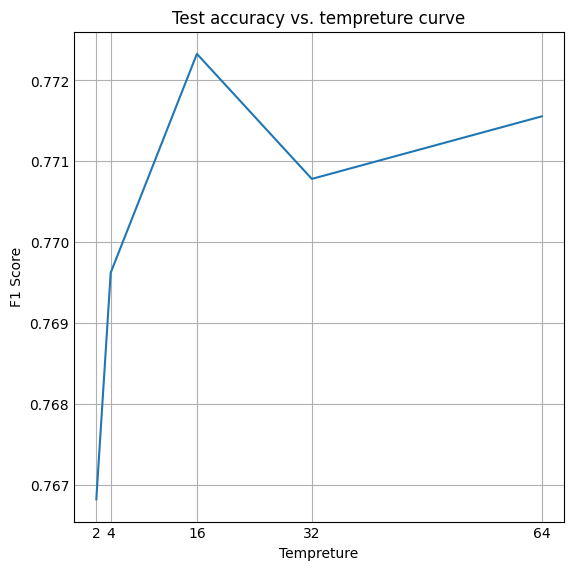

In [47]:
import math
import matplotlib.pyplot as plt
x_axis = [ 2, 4, 16, 32, 64]
plt.figure(figsize=(5,5))
plt.title("Test accuracy vs. tempreture curve")
plt.plot(x_axis,f1_list)
#new_list = range(math.floor(min(x_axis)), math.ceil(max(x_axis))+1)
plt.xticks(x_axis)
plt.xlabel('Tempreture')
plt.ylabel('F1 Score')
plt.show()

# Comparing the teacher and student model (number of of parameters and FLOPs)

In [75]:
###############
#Kaintels
#https://github.com/tensorflow/tensorflow/issues/32809
###############
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import  convert_variables_to_constants_v2_as_graph

def get_flops(model):
    concrete = tf.function(lambda inputs: model(inputs))
    concrete_func = concrete.get_concrete_function(
        [tf.TensorSpec([1, *inputs.shape[1:]]) for inputs in model.inputs])
    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(concrete_func)
    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        #opts = tf.compat.v1.profiler.ProfileOptionBuilder.trainable_variables_parameter()
        #params = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd="op", options=opts)
        return flops.total_float_ops


In [76]:
model = teacher_model
print("The FLOPs of Teacher model is:{}".format(get_flops(model)) ,flush=True )
model = student_model
print("The FLOPs of Student model with KD is:{}".format(get_flops(model)) ,flush=True )
model = student_model_no_distillation
print("The FLOPs of Student model without KD is:{}".format(get_flops(model)) ,flush=True )

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


The FLOPs of Teacher model is:6973920258
The FLOPs of Student model with KD is:599272770
The FLOPs of Student model without KD is:599272770


In [77]:
print('Teacher model:\n')
teacher_model.summary()
print('')
print('Student model with KD:\n')
student_model.summary()
print('')
print('Student model without KD:\n')
student_model_no_distillation.summary()

Teacher model:

Model: "model_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_58 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
 8 (GlobalAveragePooling2D)                                      
                                                                 
 dropout_28 (Dropout)        (None, 2048)              0         
                                                                 
 dense_28 (Dense)            (None, 2)                 4098      
                                                                 
Total params: 23568898 (89.91 MB)
Trainable params: 4098 (16.01 KB)
Non-trainable params: 23564800 (89.89 MB

# Implementing the state-of-the-art KD algorithm

In [49]:
student_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights="imagenet",
    classes=2,
)
student_model.trainable=False

# Create new model on top.
inputs = tf.keras.Input(shape=(224, 224, 3))
x = student_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(dtype='float32')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)
student_model = tf.keras.Model(inputs, outputs)


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
initial_epoch = 10
student_model.compile(optimizer=optimizer
)

In [67]:

teacher_model = tf.keras.applications.ResNet50V2(
  include_top=False,
  weights='imagenet',
  classes=2,
  input_shape=IMAGE_SHAPE
  )
teacher_model.trainable=False

# Create new model on top.
inputs = tf.keras.Input(shape=(224, 224, 3))
x = teacher_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(dtype='float32')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(2)(x)
teacher_model = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
initial_epoch = 10
teacher_model.compile(optimizer=optimizer)



In [69]:
#teacher_model = create_teacher()
#student_model = create_student()
DISTILLATION_TEMPERATURE = 4
techer_acc_list = []
student_acc_list = []
epoch_list = [2,4,8,12,24]
for epoch in epoch_list:
  NUM_EPOCHS = epoch
  #teacher_model = create_teacher()
  teacher_model = tf.keras.applications.ResNet50V2(
  include_top=False,
  weights='imagenet',
  classes=2,
  input_shape=IMAGE_SHAPE
  )
  teacher_model.trainable=False

# Create new model on top.
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = teacher_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D(dtype='float32')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(2)(x)
  teacher_model = tf.keras.Model(inputs, outputs)
  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  initial_epoch = 10
  teacher_model.compile(optimizer=optimizer)

  techer_acc_list.append(train_and_evaluate(teacher_model,compute_teacher_loss))
  NUM_EPOCHS = 12

  student_model = tf.keras.applications.MobileNetV2(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    weights="imagenet",
    classes=2,
  )
  student_model.trainable=False

# Create new model on top.
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = student_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D(dtype='float32')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Dense(2)(x)
  student_model = tf.keras.Model(inputs, outputs)


  optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
  initial_epoch = 10
  student_model.compile(optimizer=optimizer
  )

  student_acc_list.append(train_and_evaluate(student_model, compute_student_loss))
  #train_and_evaluate(fc_model, compute_student_loss)


Epoch 1: Epoch 2: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 10: Epoch 11: Epoch 12: Epoch 13: Epoch 14: Epoch 15: Epoch 16: Epoch 17: Epoch 18: Epoch 19: Epoch 20: Epoch 21: Epoch 22: Epoch 23: Epoch 24: Epoch 1: Epoch 2: Epoch 3: Epoch 4: Epoch 5: Epoch 6: Epoch 7: Epoch 8: Epoch 9: Epoch 1

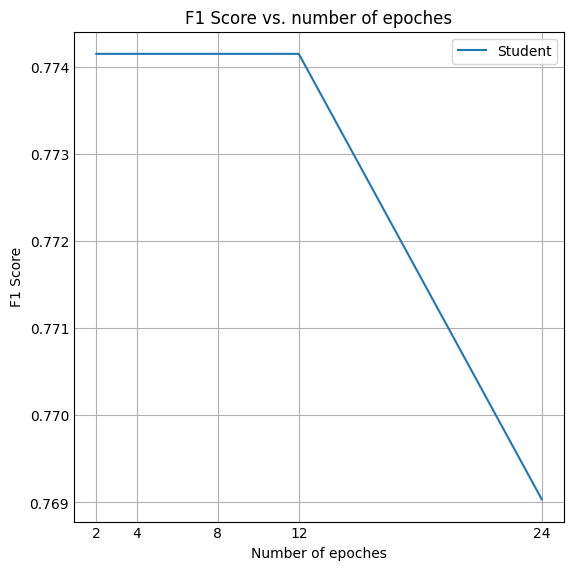

In [74]:
import math
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.title("F1 Score vs. number of epoches")
#plt.plot(epoch_list,techer_acc_list,label = 'Teacher')
plt.plot(epoch_list,student_acc_list,label = 'Student')
#new_list = range(math.floor(min(x_axis)), math.ceil(max(x_axis))+1)
plt.xticks(epoch_list)
plt.xlabel('Number of epoches')
plt.ylabel('F1 Score')
plt.legend()
plt.show()